In [1]:
from google.colab import drive
 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install transformers

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AdamW, get_linear_schedule_with_warmup
import re 
import numpy as np 
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models
from sklearn.metrics import classification_report
from collections import Counter
from collections import defaultdict
from gensim.models import KeyedVectors

In [3]:
def label_to_target(text):
  if text == "not_humanitarian":
    return 0
  elif text == "infrastructure_and_utility_damage":
    return 1
  elif text == "other_relevant_information":
    return 2
  elif text == "rescue_volunteering_or_donation_effort":
    return 3
  elif text == "affected_individuals":
    return 4


df_train = pd.read_csv("./gdrive/MyDrive/Models/train_processed.tsv", sep='\t')
df_train = df_train[['tweet_text', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)



df_val = pd.read_csv("./gdrive/MyDrive/Models/val_processed.tsv", sep='\t')
df_val = df_val[['tweet_text', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/Models/test_processed.tsv", sep='\t')
df_test = df_test[['tweet_text', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)

In [4]:
weights = KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/crisisNLP_word2vec_model/crisisNLP_word_vector.bin', binary=True)
weights = torch.FloatTensor(weights.vectors)

In [5]:
class DisasterTweetDataset(Dataset):

  def __init__(self, tweets, targets):
    self.tweets = tweets
    self.targets = targets  
  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = self.tweets[item]
    target = self.targets[item]

    tweet = tweet.split(",")
    tweet = list(map(int, tweet))

    return {
      'input_ids': torch.tensor(tweet),
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, batch_size):
  ds = DisasterTweetDataset(
    tweets=df.tweet_text.to_numpy(),
    targets=df.label_text.to_numpy()
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [6]:
class kimCNN(nn.Module):
    """
    The embedding layer + CNN model that will be used to perform analysis.
    """

    def __init__(self, weights, vocab_size, output_size, embedding_dim, num_filters=100, kernel_sizes=[3, 4, 5], freeze_embeddings=True):
        """
        Initialize the model by setting up the layers.
        """
        super(kimCNN, self).__init__()

        # set class vars
        self.num_filters = num_filters
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding.from_pretrained(weights)
        print(self.embedding)
        
        if freeze_embeddings:
            self.embedding.requires_grad = False
        
        self.x = nn.Conv2d(1,300, (5, embedding_dim))
        self.x_relu = nn.ReLU()
        self.x_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 5 + 1, 1))
        
        self.y = nn.Conv2d(1,300, (4, embedding_dim))
        self.y_relu = nn.ReLU()
        self.y_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 4 + 1, 1))


        self.z = nn.Conv2d(1,300, (3, embedding_dim))
        self.z_relu = nn.ReLU()
        self.z_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 3 + 1, 1))

        self.z1 = nn.Conv2d(1,300, (2, embedding_dim))
        self.z1_relu = nn.ReLU()
        self.z1_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 2 + 1, 1))

        self.w1 = nn.Conv2d(1,300, (1, embedding_dim))
        self.w1_relu = nn.ReLU()
        self.w1_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 1 + 1, 1))


        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.02)
        self.fc_1 = nn.Linear(1500, 100)
        self.relu_2 = nn.ReLU()
        self.fc_2 = nn.Linear(100, 50)
        self.relu_3 = nn.ReLU()
        self.fc_3 = nn.Linear(50, 5)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        """
        Defines how a batch of inputs, x, passes through the model layers.
        Returns a single, sigmoid-activated class score as output.
        """

        # embedded vectors
        embeds1 = self.embedding(x) # (batch_size, seq_length, embedding_dim)
        # embeds.unsqueeze(1) creates a channel dimension that conv layers expect
        embeds2 = embeds1.unsqueeze(1)

        x_out = self.x(embeds2)
        x_relu_out = self.x_relu(x_out)
        x_pool_out = self.x_pool(x_relu_out)

        y_out = self.y(embeds2)
        y_relu_out = self.y_relu(y_out)
        y_pool_out = self.y_pool(y_relu_out)

        z_out = self.z(embeds2)
        z_relu_out = self.z_relu(z_out)
        z_pool_out = self.z_pool(z_relu_out)

        z1_out = self.z1(embeds2)
        z1_relu_out = self.z1_relu(z1_out)
        z1_pool_out = self.z1_pool(z1_relu_out)

        w1_out = self.w1(embeds2)
        w1_relu_out = self.w1_relu(w1_out)
        w1_pool_out = self.w1_pool(w1_relu_out)

        merged_output1 = torch.cat((x_pool_out, y_pool_out, z_pool_out, z1_pool_out, w1_pool_out), dim=1)
        merged_output2 = torch.squeeze(merged_output1,3)
        merged_output3 = torch.squeeze(merged_output2,2)
        #print(merged_output.size())

        relu1_out = self.relu_1(merged_output3)

        dropout1_out = self.dropout_1(relu1_out)
        fc1_out = self.fc_1(dropout1_out)
        
        relu2_out = self.relu_2(fc1_out)
        fc2_out = self.fc_2(relu2_out)

        relu3_out = self.relu_3(fc2_out)
        fc3_out = self.fc_3(relu3_out)

        probas = self.softmax(fc3_out)

        return probas


In [10]:
# Instantiate the model w/ hyperparams

vocab_size = 2152854 #len(pretrained_words)
output_size = 1 # binary class (1 or 0)
embedding_dim = 300 #len(embed_lookup[pretrained_words[0]])
num_filters = 512
kernel_sizes = [2, 3, 4]
MAX_SEQUENCE_LENGTH = 25

batch_size = 128
EPOCHS = 300

train_data_loader = create_data_loader(df_train, batch_size)
val_data_loader = create_data_loader(df_val, batch_size)
test_data_loader = create_data_loader(df_test, batch_size)

model = kimCNN(weights, vocab_size, output_size, embedding_dim, num_filters, kernel_sizes)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=0.00001)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, betas=(0.9, 0.999))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, min_lr=0, verbose=False)



Embedding(2152854, 300)


In [11]:
def train_epoch(model, data_loader, loss_fn, optimizer,scheduler, device, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    targets = d["targets"].long() 
    targets = targets.to(device)

    outputs = model(x=input_ids)


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.max(outputs, dim=1).indices == targets) 
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      targets = d["targets"].long()
      targets = targets.to(device)

      outputs = model(x=input_ids)
      # print(outputs, targets)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.max(outputs, dim=1).indices == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [14]:
# history = defaultdict(list)
# start_epoch = 0
# best_accuracy = -1

checkpoint = torch.load("./gdrive/MyDrive/Models/KimCNN/checkpoint.t7")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']

print(start_epoch)


# for epoch in range(EPOCHS):

#   print(f'Epoch {start_epoch + epoch + 1}/{start_epoch + EPOCHS}')
#   print('-' * 10)

#   train_acc, train_loss = train_epoch(
#     model,
#     train_data_loader,    
#     loss_fn, 
#     optimizer,
#     scheduler, 
#     device, 
#     len(df_train)
#   )

#   print(f'Train loss {train_loss} accuracy {train_acc}')

#   val_acc, val_loss = eval_model(
#     model,
#     val_data_loader,
#     loss_fn, 
#     device, 
#     len(df_val)
#   )

#   # scheduler.step(val_acc)

#   print(f'Val   loss {val_loss} accuracy {val_acc}')
#   print()

#   history['train_acc'].append(train_acc)
#   history['train_loss'].append(train_loss)
#   history['val_acc'].append(val_acc)
#   history['val_loss'].append(val_loss)

#   if val_acc > best_accuracy:
#     state = {
#             'best_accuracy': val_acc,
#             'epoch': start_epoch+epoch+1,
#             'state_dict': model.state_dict(),
#             'optimizer': optimizer.state_dict(),
#     }
#     savepath= "./gdrive/MyDrive/Models/KimCNN/checkpoint.t7"
#     torch.save(state,savepath)
#     best_accuracy = val_acc

# state = {
#         'epoch': start_epoch + EPOCHS,
#         'state_dict': model.state_dict(),
#         'optimizer': optimizer.state_dict(),
# }
# savepath= "./gdrive/MyDrive/Models/KimCNN/checkpoint-{}.t7".format(start_epoch + EPOCHS)
# torch.save(state,savepath)

# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')

# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1]);

251


In [ ]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/KimCNN/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

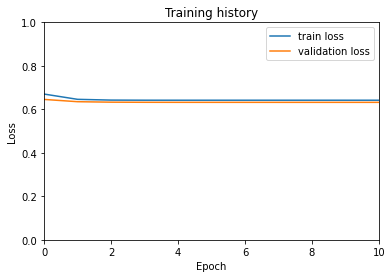

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [15]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      targets = d["targets"].long()
      targets = targets.to(device)

      outputs = model(
        x=input_ids,
      )
      preds = torch.max(outputs, dim=1).indices


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['not_humanitarian', 'infrastructure_and_utility_damage', 'other_relevant_information', 'rescue_volunteering_or_donation_effort', 'affected_individuals'], digits = 4))

                                        precision    recall  f1-score   support

                      not_humanitarian     0.7039    0.8869    0.7849       504
     infrastructure_and_utility_damage     0.7451    0.4691    0.5758        81
            other_relevant_information     0.7118    0.5149    0.5975       235
rescue_volunteering_or_donation_effort     0.7475    0.5873    0.6578       126
                  affected_individuals     0.0000    0.0000    0.0000         9

                              accuracy                         0.7120       955
                             macro avg     0.5817    0.4916    0.5232       955
                          weighted avg     0.7085    0.7120    0.6969       955



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
